In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNb08 activation

In [3]:
simType = "DNb08_Stim"
simPath = simType+"/hyak/run_id=28357516"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActiveTinyThreshold = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActiveTinyThreshold.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [5]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

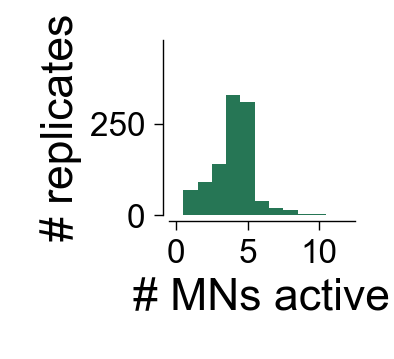

In [6]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)
plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

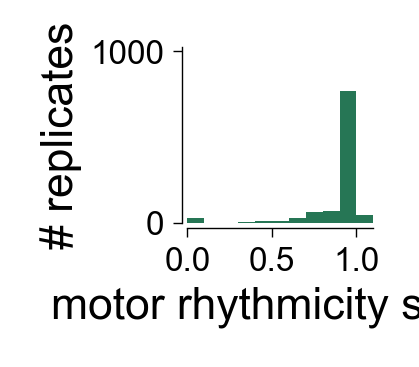

In [7]:
# plt.figure(figsize=(1.426,0.563))
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## MANC 1024x DNb08 pruning

In [40]:
simType = "DNb08_Stim_Prune"
simPath = simType+"/hyak/run_id=28357547"
folder = dataPath + simPath
minicircuits = sparse.load_npz(folder+f"/ckpt/{simType}_mini_circuits.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
minicircuits = minicircuits[dataset]
nRuns = minicircuits.shape[0]

wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [43]:
minicircuitsDf = pd.DataFrame(data=minicircuits,columns = wTable.bodyId)
minicircuitsDf = minicircuitsDf.iloc[:,np.argsort(np.sum(minicircuitsDf.values, 0))]
minicircuitsDf[14061] = False #exclude DNb08
minicircuitsDf

bodyId,25015,25110,25090,25082,25064,25052,25050,25041,25018,25125,...,10390,10715,21162,13905,10242,10707,11751,12021,162543,14061
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,True,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,True,True,True,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,True,True,True,False
1020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,True,True,True,False
1021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,True,True,True,False
1022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,True,True,True,False


In [44]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

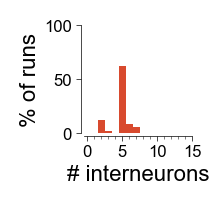

In [45]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(90),edgecolor=None,stat="percent",alpha=1,discrete=True)
ax.set_xlim(-0.5,14.5)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("# interneurons")
ax.set_ylabel("% of runs")
ax.set_xticks(np.arange(0,16,5))
ax.set_xticks(np.arange(0,16,1),minor=True,)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.7)
fig.set_figwidth(0.7)
# plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNIns.svg",transparent=True)
plt.show()

In [46]:
orderedInPrevalences = minicircuitsDf.transpose().sum(1).sort_values(ascending=False)
orderedInPcts = orderedInPrevalences / nRuns * 100
orderedInNts = orderedInPcts.index.map(dict(zip(wTable["bodyId"],wTable["predictedNt"])))
ntColors = {"acetylcholine":excColor,"gaba":inhColor,"glutamate":inhColor}
orderedColors = orderedInNts.map(ntColors)

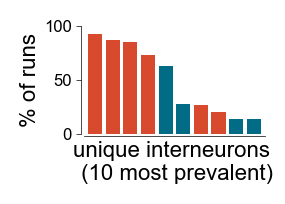

In [55]:
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
plt.xticks([])
plt.ylabel("% of runs")
plt.xlabel("unique interneurons \n (10 most prevalent)")

plt.ylim([0,100])

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_figheight(0.7)
fig.set_figwidth(1.172)
# fig.set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
plt.show()

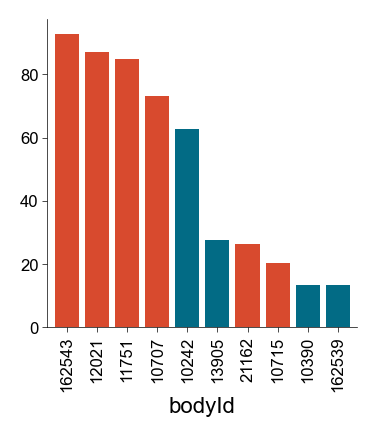

In [57]:
# labeled version
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
# plt.xticks(rotation=45)
# plt.ylabel("% of runs")
# plt.xlabel("unique interneurons \n (10 most prevalent)")

# plt.ylim([0,100])

# ax.spines[["top","right"]].set_visible(False)
# ax.tick_params(axis='both', which='major', labelsize=6)
# fig.set_figheight(0.7)
# fig.set_figwidth(1.172)
# # fig.set_dpi(400)

# sns.despine(offset=1)

# # if not os.path.exists(figFolder):
# #     os.makedirs(figFolder)
# # plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
# plt.show()

## looking at stuff

In [73]:
np.where(minicircuitsDf.loc[minicircuitsDf.sum(1)==2])[1].reshape(127,2)

array([[4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4596, 4602],
       [4601, 4602],
       [4601, 4602],
       [4596, 4601],
       [4596, 4601],
       [4596, 4601],
       [4596, 4601],
       [4596,

In [88]:
np.asarray(minicircuitsDf.columns[np.where(minicircuitsDf.loc[minicircuitsDf.sum(1)==2])[1]]).reshape(127,2)

array([[ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],
       [ 21162, 162543],


In [98]:
np.unique(np.asarray(minicircuitsDf.columns[np.where(minicircuitsDf.loc[minicircuitsDf.sum(1)==2])[1]]).reshape(127,2),axis=0,return_counts=True)

(array([[ 10390,  12021],
        [ 12021, 162543],
        [ 20037, 162543],
        [ 21162,  12021],
        [ 21162, 162543]]),
 array([ 2,  5, 51, 28, 41]))

In [84]:
wTable.loc[wTable["bodyId"].isin([10390,  12021,  20037,  21162, 162543])]

,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
150,150,10390,IN12B003,intrinsic neuron,BR,12B,4407248281,gaba,0.860695,0.021053,0.860695,0.115803,RHS,NaN,NaN
693,693,12021,IN03A006,intrinsic neuron,IR,03A,2470525558,acetylcholine,0.819702,0.820702,0.036806,0.138777,LHS,NaN,NaN
2340,2340,20037,IN20A.22A015,intrinsic neuron,IR,20A.22A,556059504,acetylcholine,0.596136,0.596136,0.067627,0.328767,LHS,NaN,NaN
2534,2534,21162,IN20A.22A036,intrinsic neuron,IR,20A.22A,621360860,acetylcholine,0.613756,0.613756,0.104834,0.278540,LHS,NaN,NaN
4458,4458,162543,INXXX464,intrinsic neuron,IR,TBD,4605118530,acetylcholine,0.815799,0.816496,0.035966,0.143709,LHS,NaN,NaN


In [83]:
np.unique(np.asarray(minicircuitsDf.columns[np.where(minicircuitsDf.loc[minicircuitsDf.sum(1)==2])[1]]).reshape(127,2))

array([ 10390,  12021,  20037,  21162, 162543])

In [97]:
np.unique(np.asarray(minicircuitsDf.columns[np.where([minicircuitsDf.loc[minicircuitsDf.sum(1)==5]])[2]]).reshape(636,5),axis=0,return_counts=True)

(array([[ 10242,  10707,  11751,  12021, 162543],
        [ 10715,  13905,  10707,  11751,  12021],
        [ 10715,  13905,  11751,  12021, 162543],
        [ 13905,  10707,  11751,  12021, 162543],
        [ 20037,  10242,  10707,  11751, 162543],
        [ 21162,  10242,  10707,  11751,  12021],
        [ 21162,  10242,  10707,  11751, 162543],
        [162539,  10390,  10707,  12021, 162543]]),
 array([403,   1, 131,  68,   7,   1,  24,   1]))

In [91]:
3180/5

636.0